# ***Ch10: Uncertainty Intervals***

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import numpy as np
np.random.seed(42)

df = pd.read_csv('../data/baltimore_crime.csv')
df.columns = ['ds', 'y']

In [5]:
df

,ds,y
0,2014-01-01,138
1,2014-01-02,110
2,2014-01-03,72
3,2014-01-04,118
4,2014-01-05,104
...,...,...
3283,2013-12-27,115
3284,2013-12-28,143
3285,2013-12-29,148
3286,2013-12-30,121


## *Modeling uncertainty in trend*

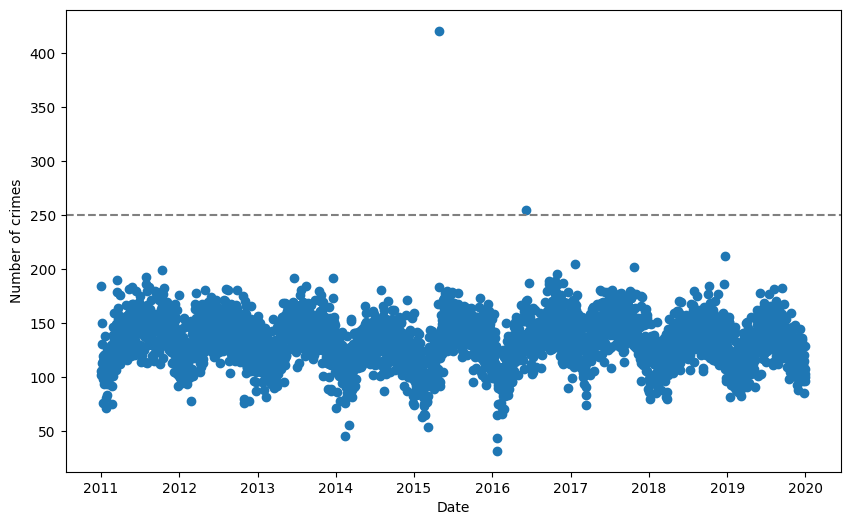

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(pd.to_datetime(df['ds']), df['y'])
plt.axhline(250, ls='--', c='gray')
plt.xlabel('Date')
plt.ylabel('Number of crimes')
plt.show()

# 'Baltimore Crime data'
# horizontal line at 250[crimes/day]

In [6]:
# Remove outliers
df.loc[df['y'] > 250, 'y'] = None

17:16:32 - cmdstanpy - INFO - Chain [1] start processing
17:16:33 - cmdstanpy - INFO - Chain [1] done processing


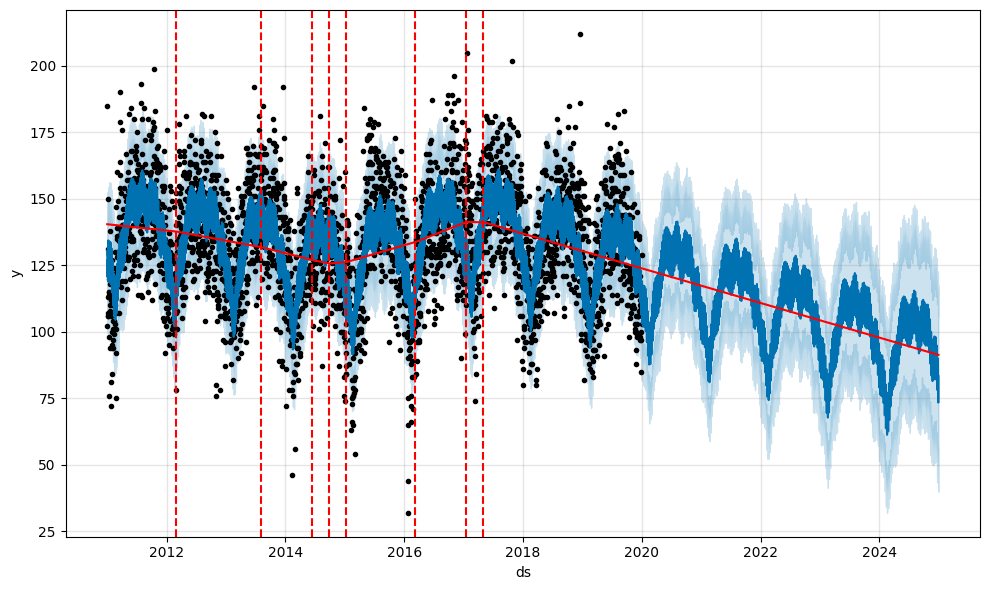

In [7]:
# The number of Monte Carlo simulations Prophet runs through, uncertainty_samples
model = Prophet(uncertainty_samples=1000)
model.fit(df)
future = model.make_future_dataframe(periods=365 * 5)
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

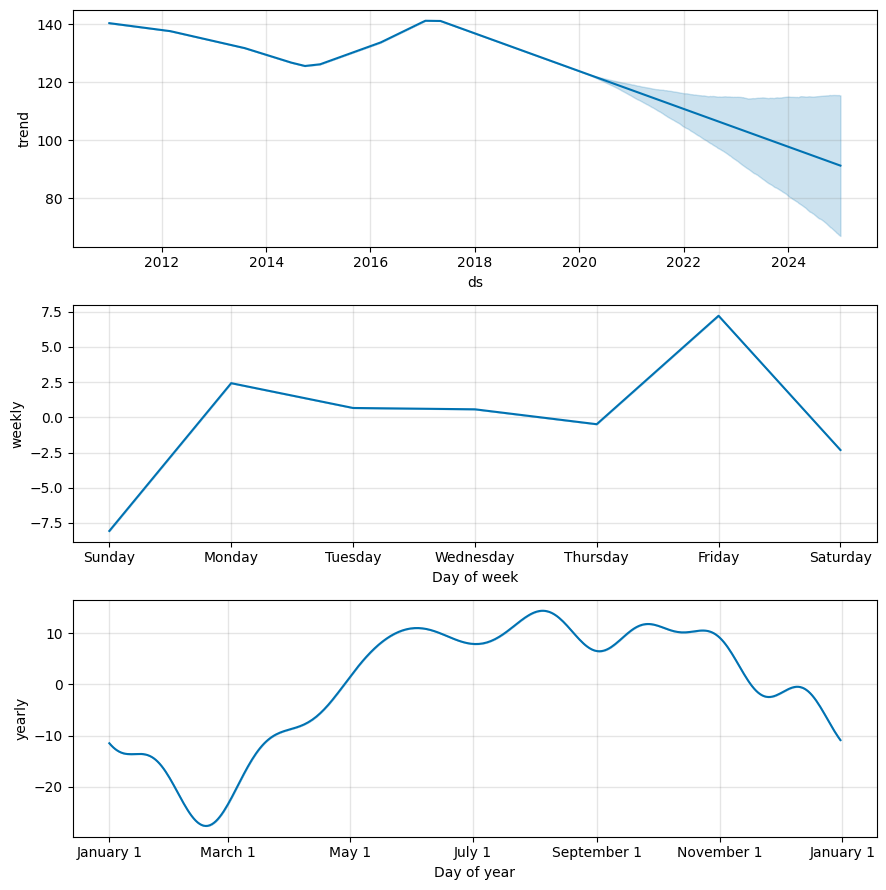

In [8]:
fig2 = model.plot_components(forecast)
plt.show()

In [9]:
# Saving for use later
m0 = model
f0 = forecast

In [10]:
'''
Prophet saved each result in the predictive_samples attribute of the model. 
This is a dictionary with keys of 'yhat' and 'trend', storing, respectively, 
the estimated values for the total prediction and the prediction of just the trend, 
for each iteration:
'''

samples = model.predictive_samples(future)

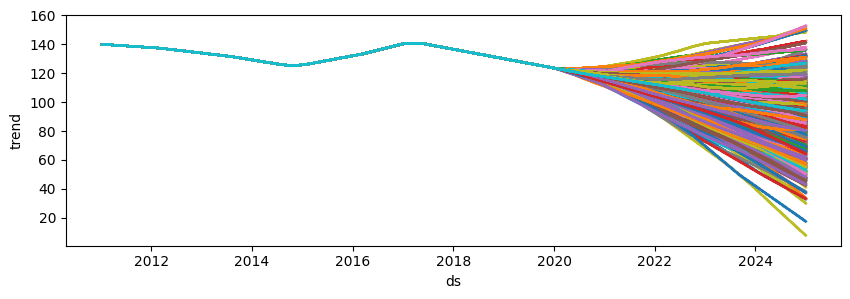

In [11]:
# samples = model.predictive_samples(future)

plt.figure(figsize=(10, 3))
for idx in range(model.uncertainty_samples):
    plt.scatter(future['ds'], samples['trend'][:, idx], s=.1, alpha=1)
plt.xlabel('ds')
plt.ylabel('trend')
plt.show()

In [12]:
# 99% confidence level , interval_width=0.99

model = Prophet(interval_width=0.99)
model.fit(df)
future = model.make_future_dataframe(periods=365 * 5)
forecast = model.predict(future)

17:46:49 - cmdstanpy - INFO - Chain [1] start processing
17:46:50 - cmdstanpy - INFO - Chain [1] done processing


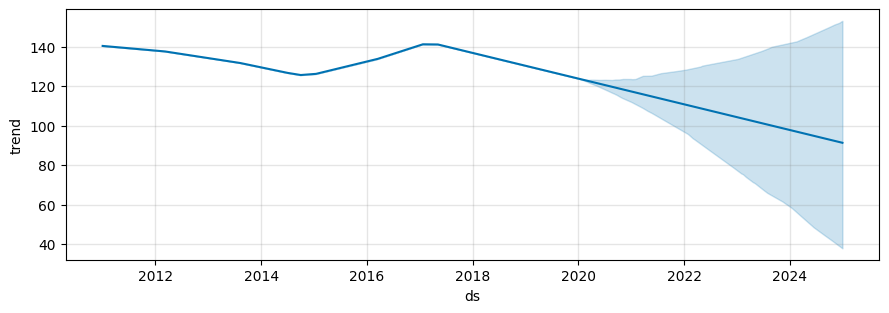

In [13]:
from prophet.plot import plot_forecast_component

plot_forecast_component(model,
                        forecast,
                        'trend',
                        figsize=(10.5, 3.25))
plt.show()

## *Modeling uncertainty in seasonality*

18:09:28 - cmdstanpy - INFO - CmdStan installation /home/worker/miniconda3/envs/fbprophet/lib/python3.9/site-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
18:09:28 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
18:09:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:11:07 - cmdstanpy - INFO - CmdStan done processing.
18:11:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but

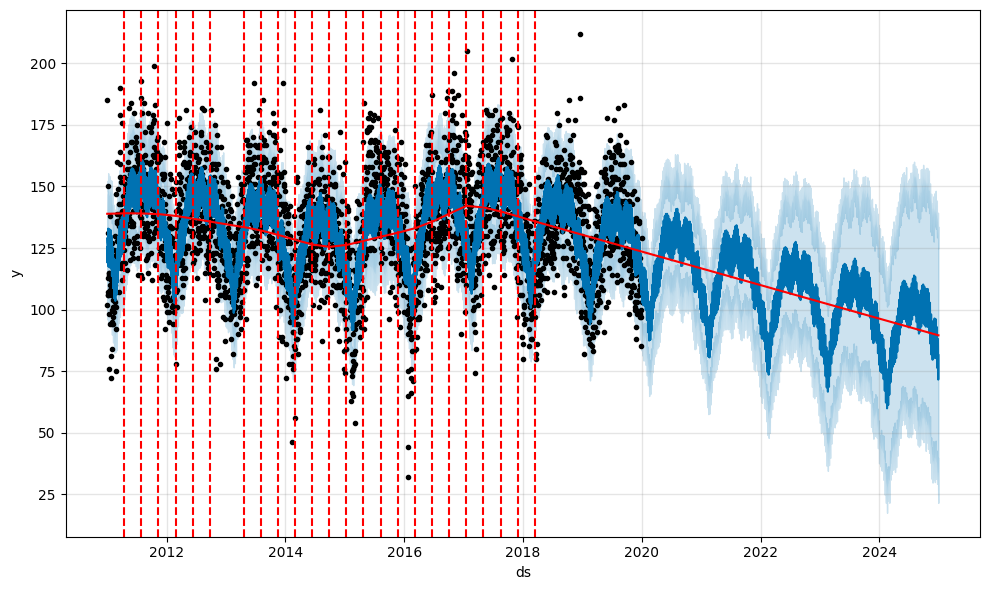

In [16]:
model = Prophet(mcmc_samples=300)
model.fit(df)
future = model.make_future_dataframe(periods=365 * 5)
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

# many change points issue , explain later

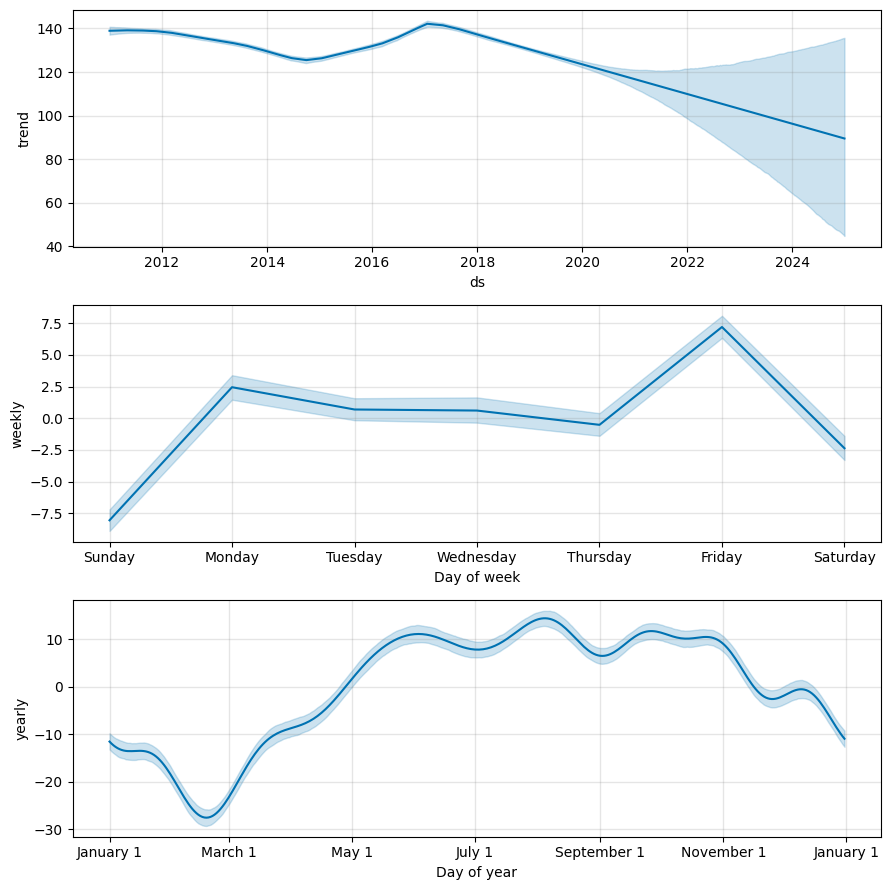

In [17]:
fig2 = model.plot_components(forecast)
plt.show()

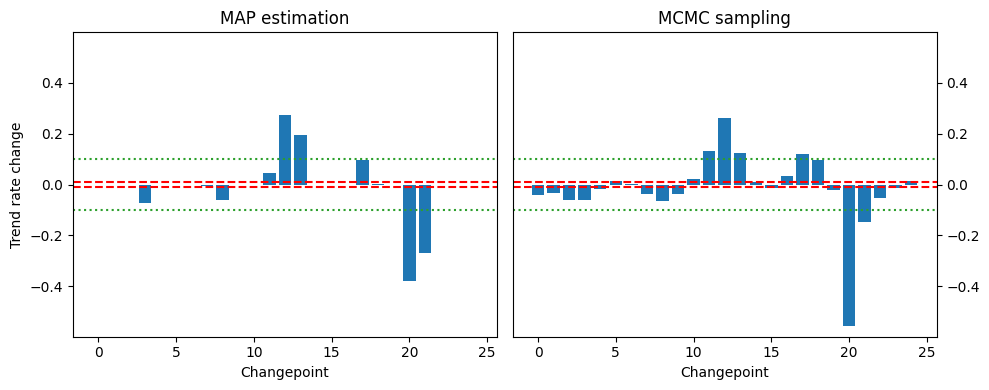

In [19]:
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(121)
ax1.bar(np.arange(25), np.nanmean(m0.params['delta'], axis=0))
ax1.set_title('MAP estimation')
ax1.set_xlabel('Changepoint')
ax1.set_ylabel('Trend rate change')
ax1.axhline(y=0.01, color='r', ls='--')
ax1.axhline(y=-0.01, color='r', ls='--')
ax1.axhline(y=0.1, color='tab:green', ls=':')
ax1.axhline(y=-0.1, color='tab:green', ls=':')

ax2 = fig.add_subplot(122)
ax2.bar(np.arange(25), np.nanmean(model.params['delta'], axis=0))
ax2.set_xlabel('Changepoint')
ax2.axhline(y=0.01, color='r', ls='--')
ax2.axhline(y=-0.01, color='r', ls='--')
ax2.axhline(y=0.1, color='tab:green', ls=':')
ax2.axhline(y=-0.1, color='tab:green', ls=':')
ax2.set_title('MCMC sampling')
ax2.yaxis.tick_right()

ylim = max([abs(val) for val in ax1.get_ylim() + ax2.get_ylim()])
ax1.set_ylim(-ylim, ylim)
ax2.set_ylim(-ylim, ylim)

plt.tight_layout()
plt.show()

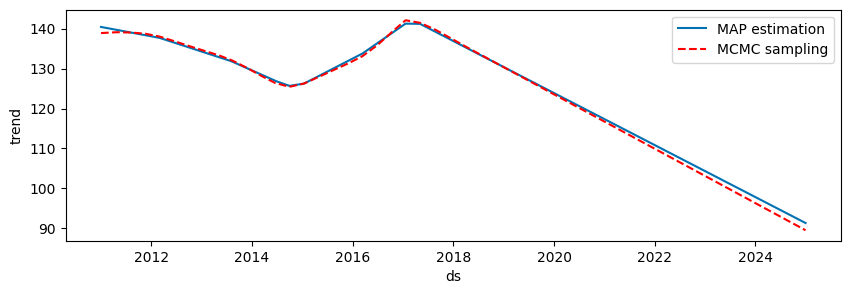

In [20]:
# Too many change points when using MCMC sampling is
# just visualization problem
# adjust 'threshold' in add_change_point_plot()

plt.figure(figsize=(10, 3))

plt.plot(f0['ds'], f0['trend'], color='#0072B2', label='MAP estimation')

plt.plot(forecast['ds'], forecast['trend'], color='r', ls='--', label='MCMC sampling')

plt.ylabel('trend')
plt.xlabel('ds')
plt.legend()
plt.show()

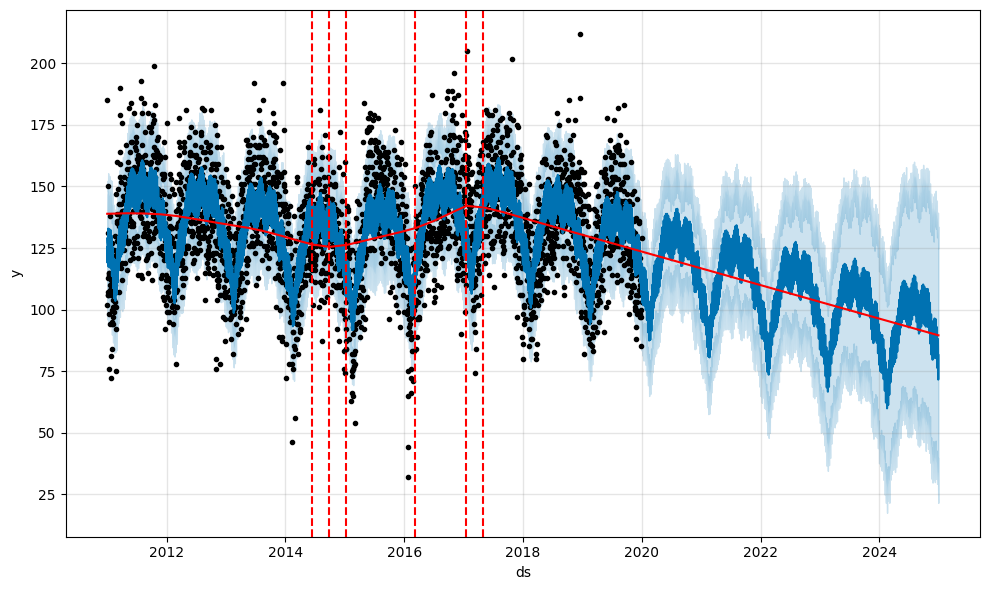

In [21]:
# Adjust threshold in add_changepoints_to_plot

fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast, threshold=0.1)
plt.show()

In [22]:
# Saving for use later
m1 = model
f1 = forecast

23:23:34 - cmdstanpy - INFO - CmdStan installation /home/worker/miniconda3/envs/fbprophet/lib/python3.9/site-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
23:23:34 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
23:23:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:24:52 - cmdstanpy - INFO - CmdStan done processing.
23:24:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but

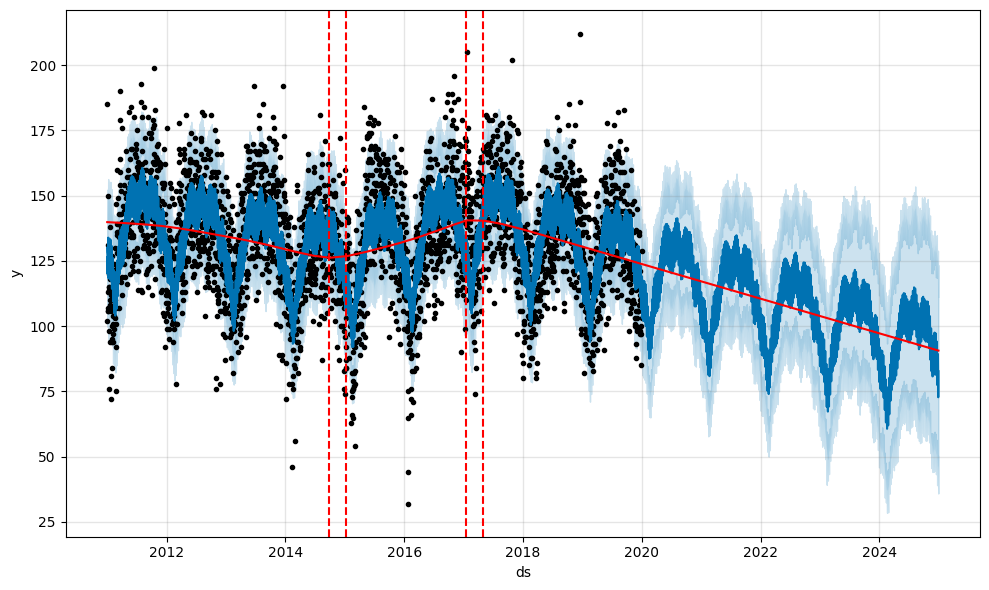

In [23]:
# If there are many changepoints , adjust 'changepoints_prior_scale'

model = Prophet(changepoint_prior_scale=0.03,
                mcmc_samples=300)
model.fit(df)
future = model.make_future_dataframe(periods=365 * 5)
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast, threshold=0.1)
plt.show()

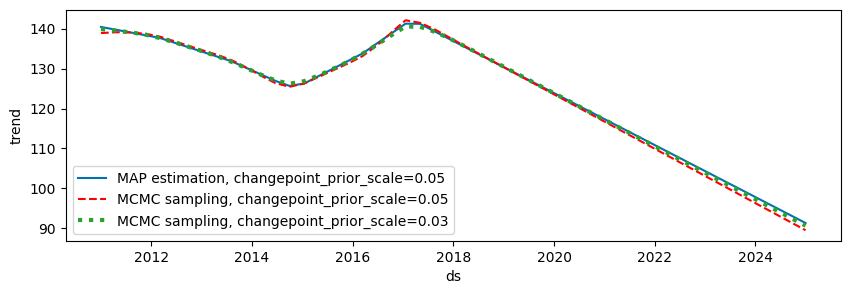

In [24]:
'''
If we compare the trend lines, 
we see that this regularized line matches the original MAP estimation 
ever so slightly better
'''

plt.figure(figsize=(10, 3))

plt.plot(f0['ds'],
         f0['trend'],
         color='#0072B2',
         label='MAP estimation, changepoint_prior_scale=0.05')

plt.plot(f1['ds'],
         f1['trend'],
         color='r',
         ls='--',
         label='MCMC sampling, changepoint_prior_scale=0.05')

plt.plot(forecast['ds'],
         forecast['trend'],
         color='tab:green',
         ls=':',
         lw=3,
         label='MCMC sampling, changepoint_prior_scale=0.03')

plt.ylabel('trend')
plt.xlabel('ds')
plt.legend()
plt.show()